# Graph Neural Networks (GNNs)

## What are GNNs?

Graph Neural Networks (GNNs) are a class of neural networks designed to work with graph-structured data. Unlike traditional neural networks that work with grid-like data (images) or sequences (text), GNNs can process data where the relationships between entities are explicitly represented as edges in a graph.

### Key Concepts:

1. **Graphs**: Consist of nodes (vertices) and edges (connections between nodes)
2. **Node Features**: Attributes associated with each node
3. **Edge Features**: Attributes associated with connections (optional)
4. **Message Passing**: Nodes aggregate information from their neighbors
5. **Graph-level Tasks**: Node classification, link prediction, graph classification

### Applications:
- Social network analysis
- Molecular property prediction
- Recommendation systems
- Traffic prediction
- Knowledge graphs

In this tutorial, we'll implement a GNN for node classification using the Cora citation network dataset.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Try to import torch_geometric - handle potential import issues
try:
    from torch_geometric.datasets import Planetoid
    from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
    from torch_geometric.utils import to_networkx
    TORCH_GEOMETRIC_AVAILABLE = True
    print("torch_geometric imported successfully")
except ImportError as e:
    print(f"Warning: torch_geometric not available: {e}")
    print("Please install with: pip install torch_geometric")
    TORCH_GEOMETRIC_AVAILABLE = False

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

if not TORCH_GEOMETRIC_AVAILABLE:
    print("\nNote: This notebook requires torch_geometric to run.")
    print("Some cells may not work without it.")

torch_geometric imported successfully
Using device: cpu


## Loading the Cora Dataset

The Cora dataset is a citation network where:
- **Nodes** represent scientific publications
- **Edges** represent citation links between papers
- **Node features** are bag-of-words representations of papers
- **Node labels** are the subject categories of papers (7 classes)

This is a transductive learning task where we have access to all nodes during training but only some labels.

In [2]:
# Load the Cora dataset
if not TORCH_GEOMETRIC_AVAILABLE:
    print("Cannot load dataset - torch_geometric not available")
    print("Please install torch_geometric and restart the notebook")
else:
    dataset = Planetoid(root='./data/Cora', name='Cora')
    data = dataset[0].to(device)

    # Dataset statistics
    print(f'Dataset: {dataset}')
    print('='*50)
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Number of features per node: {data.num_node_features}')
    print(f'Number of classes: {dataset.num_classes}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('='*50)
    print(f'Training nodes: {data.train_mask.sum().item()}')
    print(f'Validation nodes: {data.val_mask.sum().item()}')
    print(f'Test nodes: {data.test_mask.sum().item()}')

Dataset: Cora()
Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Training nodes: 140
Validation nodes: 500
Test nodes: 1000


Processing...
Done!


## Visualizing the Graph Structure

Let's visualize a small subgraph to understand the structure

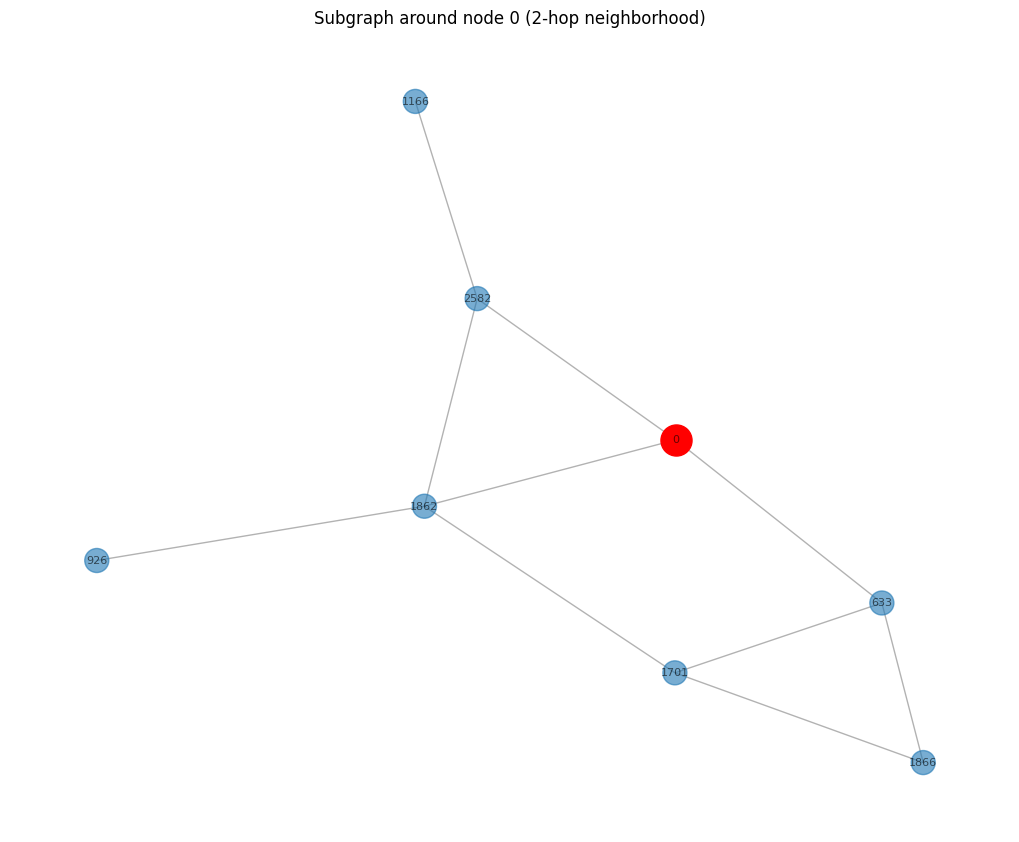

In [3]:
def visualize_subgraph(data, node_idx, num_hops=2, max_nodes=50):
    """Visualize a subgraph around a specific node"""
    # Convert to NetworkX graph
    G = to_networkx(data, to_undirected=True)
    
    # Get subgraph
    nodes = {node_idx}
    for _ in range(num_hops):
        neighbors = set()
        for node in nodes:
            neighbors.update(G.neighbors(node))
        nodes.update(neighbors)
        if len(nodes) > max_nodes:
            nodes = set(list(nodes)[:max_nodes])
            break
    
    subgraph = G.subgraph(nodes)
    
    # Create layout
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
    
    # Get node colors based on labels
    node_colors = [data.y[node].item() for node in subgraph.nodes()]
    
    # Plot
    plt.figure(figsize=(10, 8))
    nx.draw(subgraph, pos, node_color=node_colors, 
            with_labels=True, node_size=300, 
            cmap='tab10', font_size=8,
            edge_color='gray', alpha=0.6)
    
    # Highlight the center node
    if node_idx in subgraph.nodes():
        nx.draw_networkx_nodes(subgraph, pos, nodelist=[node_idx],
                             node_color='red', node_size=500)
    
    plt.title(f'Subgraph around node {node_idx} (2-hop neighborhood)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a subgraph
visualize_subgraph(data.cpu(), node_idx=0, num_hops=2)

## Understanding Message Passing

The core idea of GNNs is **message passing**: each node aggregates information from its neighbors to update its representation. This process is repeated for multiple layers, allowing information to propagate through the graph.

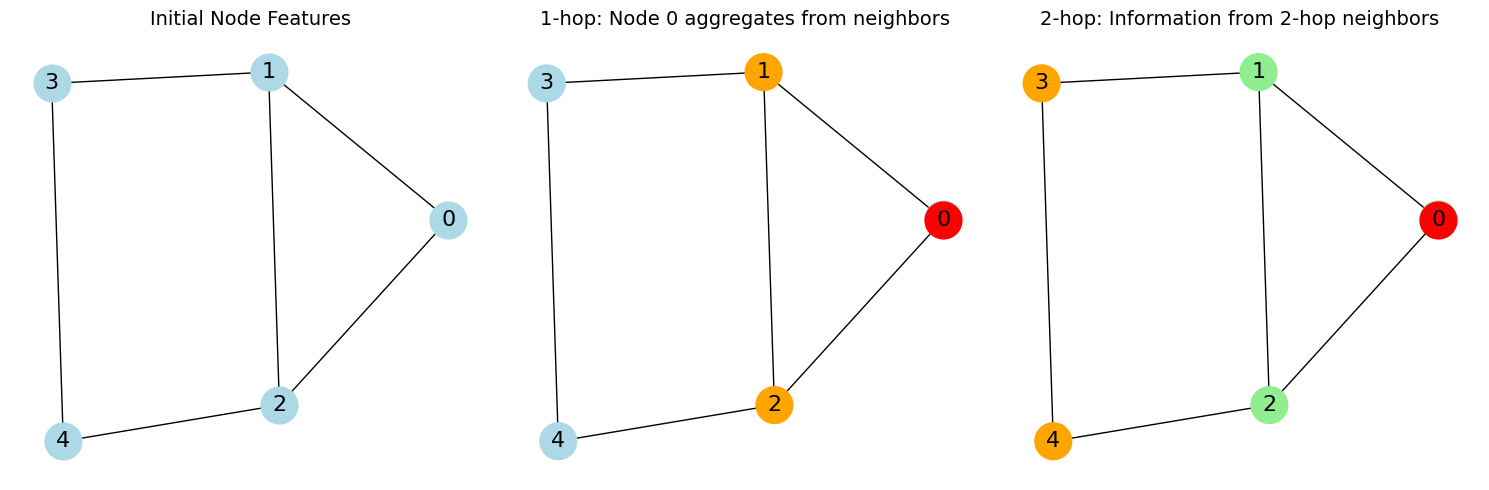

In [4]:
def visualize_message_passing():
    """Visualize the message passing concept"""
    # Create a simple graph for illustration
    G = nx.Graph()
    G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Initial state
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, ax=axes[0], with_labels=True, 
            node_color='lightblue', node_size=700, font_size=16)
    axes[0].set_title('Initial Node Features', fontsize=14)
    
    # After 1 hop
    node_colors = ['orange' if node in [1, 2] else 'lightblue' for node in G.nodes()]
    nx.draw(G, pos, ax=axes[1], with_labels=True,
            node_color=node_colors, node_size=700, font_size=16)
    nx.draw_networkx_nodes(G, pos, nodelist=[0], 
                         node_color='red', node_size=700, ax=axes[1])
    axes[1].set_title('1-hop: Node 0 aggregates from neighbors', fontsize=14)
    
    # After 2 hops
    node_colors = ['orange' if node in [3, 4] else 'lightgreen' for node in G.nodes()]
    nx.draw(G, pos, ax=axes[2], with_labels=True,
            node_color=node_colors, node_size=700, font_size=16)
    nx.draw_networkx_nodes(G, pos, nodelist=[0], 
                         node_color='red', node_size=700, ax=axes[2])
    axes[2].set_title('2-hop: Information from 2-hop neighbors', fontsize=14)
    
    plt.tight_layout()
    plt.show()

visualize_message_passing()

## Building GNN Models

We'll implement three popular GNN architectures:
1. **GCN (Graph Convolutional Network)**: Simple spectral-based convolution
2. **GAT (Graph Attention Network)**: Uses attention mechanism for aggregation
3. **Custom Message Passing**: Our own implementation to understand the mechanics

In [5]:
# 1. Graph Convolutional Network (GCN)
class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Output layer
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)

# 2. Graph Attention Network (GAT)
class GAT(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * heads, num_classes, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

# 3. Custom Message Passing Network
class CustomGNN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super(CustomGNN, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        self.dropout = dropout
        
    def aggregate_neighbors(self, x, edge_index):
        """Simple mean aggregation of neighbor features"""
        row, col = edge_index
        num_nodes = x.size(0)
        
        # Create adjacency matrix
        adj = torch.zeros((num_nodes, num_nodes), device=x.device)
        adj[row, col] = 1
        
        # Normalize by degree
        degree = adj.sum(dim=1, keepdim=True)
        degree[degree == 0] = 1  # Avoid division by zero
        norm_adj = adj / degree
        
        # Aggregate neighbor features
        return torch.matmul(norm_adj, x)
    
    def forward(self, x, edge_index):
        # Initial transformation
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Message passing
        x = self.aggregate_neighbors(x, edge_index)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final layer
        x = self.aggregate_neighbors(x, edge_index)
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

# Create model instances
gcn_model = GCN(data.num_node_features, 16, dataset.num_classes).to(device)
gat_model = GAT(data.num_node_features, 8, dataset.num_classes).to(device)
custom_model = CustomGNN(data.num_node_features, 64, dataset.num_classes).to(device)

print("GCN Model:")
print(gcn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in gcn_model.parameters()):,}")

GCN Model:
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 7)
)

Total parameters: 23,335


## Training the GNN Models

In [6]:
def train_model(model, data, epochs=200, lr=0.01, weight_decay=5e-4):
    """Train a GNN model"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    model.train()
    for epoch in range(epochs):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            pred = model(data.x, data.edge_index).argmax(dim=1)
            
            # Training accuracy
            train_correct = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
            train_acc = train_correct / data.train_mask.sum().item()
            
            # Validation accuracy
            val_correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
            val_acc = val_correct / data.val_mask.sum().item()
            
            # Validation loss
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask]).item()
        
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        model.train()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, '
                  f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accs, val_accs

# Train GCN model
print("Training GCN Model...")
gcn_losses = train_model(gcn_model, data, epochs=200)

Training GCN Model...
Epoch 20/200, Loss: 0.4180, Train Acc: 0.9857, Val Acc: 0.7800
Epoch 40/200, Loss: 0.1402, Train Acc: 1.0000, Val Acc: 0.7780
Epoch 60/200, Loss: 0.0773, Train Acc: 1.0000, Val Acc: 0.7680
Epoch 80/200, Loss: 0.0616, Train Acc: 1.0000, Val Acc: 0.7660
Epoch 100/200, Loss: 0.0352, Train Acc: 1.0000, Val Acc: 0.7660
Epoch 120/200, Loss: 0.0537, Train Acc: 1.0000, Val Acc: 0.7700
Epoch 140/200, Loss: 0.0420, Train Acc: 1.0000, Val Acc: 0.7600
Epoch 160/200, Loss: 0.0446, Train Acc: 1.0000, Val Acc: 0.7660
Epoch 180/200, Loss: 0.0431, Train Acc: 1.0000, Val Acc: 0.7480
Epoch 200/200, Loss: 0.0564, Train Acc: 1.0000, Val Acc: 0.7580


## Visualizing Training Progress

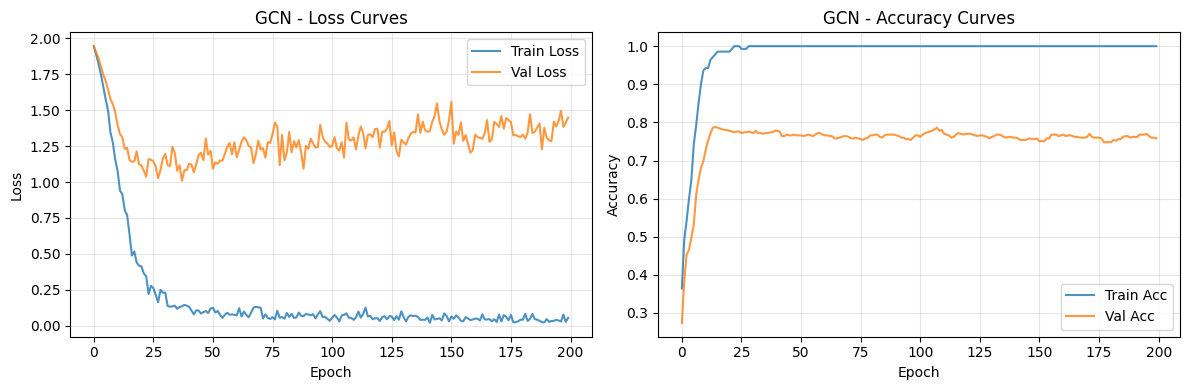

In [7]:
def plot_training_curves(losses, title="GCN"):
    """Plot training and validation curves"""
    train_losses, val_losses, train_accs, val_accs = losses
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curves
    ax1.plot(train_losses, label='Train Loss', alpha=0.8)
    ax1.plot(val_losses, label='Val Loss', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss Curves')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(train_accs, label='Train Acc', alpha=0.8)
    ax2.plot(val_accs, label='Val Acc', alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title} - Accuracy Curves')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(gcn_losses, "GCN")

## Comparing Different GNN Architectures

In [8]:
# Train GAT model
print("Training GAT Model...")
gat_losses = train_model(gat_model, data, epochs=200, lr=0.005)

# Train Custom model
print("\nTraining Custom GNN Model...")
custom_losses = train_model(custom_model, data, epochs=200, lr=0.01)

Training GAT Model...
Epoch 20/200, Loss: 0.7905, Train Acc: 0.9714, Val Acc: 0.7820
Epoch 40/200, Loss: 0.5897, Train Acc: 1.0000, Val Acc: 0.7640
Epoch 60/200, Loss: 0.4656, Train Acc: 1.0000, Val Acc: 0.7740
Epoch 80/200, Loss: 0.4573, Train Acc: 1.0000, Val Acc: 0.7640
Epoch 100/200, Loss: 0.4287, Train Acc: 1.0000, Val Acc: 0.7760
Epoch 120/200, Loss: 0.4401, Train Acc: 1.0000, Val Acc: 0.7680
Epoch 140/200, Loss: 0.3805, Train Acc: 1.0000, Val Acc: 0.7780
Epoch 160/200, Loss: 0.3240, Train Acc: 1.0000, Val Acc: 0.7720
Epoch 180/200, Loss: 0.4609, Train Acc: 1.0000, Val Acc: 0.7820
Epoch 200/200, Loss: 0.4387, Train Acc: 1.0000, Val Acc: 0.7800

Training Custom GNN Model...
Epoch 20/200, Loss: 0.0281, Train Acc: 1.0000, Val Acc: 0.7880
Epoch 40/200, Loss: 0.0114, Train Acc: 1.0000, Val Acc: 0.7860
Epoch 60/200, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7760
Epoch 80/200, Loss: 0.0103, Train Acc: 1.0000, Val Acc: 0.7660
Epoch 100/200, Loss: 0.0090, Train Acc: 1.0000, Val Acc: 0.7

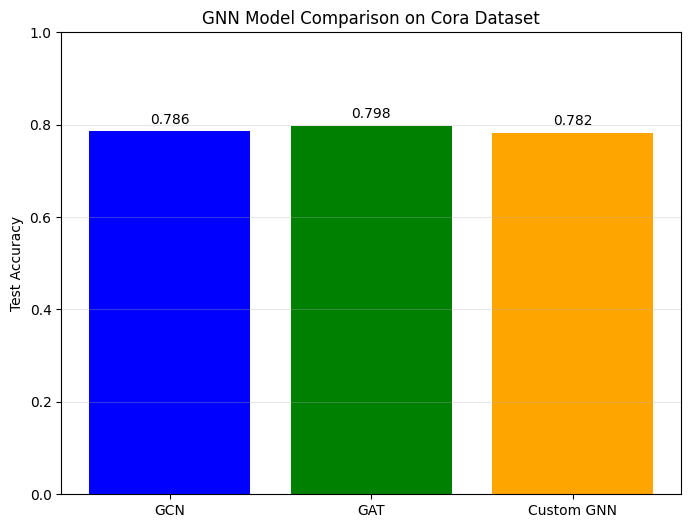

Test Accuracies:
GCN: 0.7860
GAT: 0.7980
Custom GNN: 0.7820


In [9]:
# Compare final performance
def evaluate_model(model, data, mask):
    """Evaluate model performance"""
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index).argmax(dim=1)
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
    return acc

# Evaluate all models on test set
gcn_test_acc = evaluate_model(gcn_model, data, data.test_mask)
gat_test_acc = evaluate_model(gat_model, data, data.test_mask)
custom_test_acc = evaluate_model(custom_model, data, data.test_mask)

# Plot comparison
models = ['GCN', 'GAT', 'Custom GNN']
test_accs = [gcn_test_acc, gat_test_acc, custom_test_acc]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, test_accs, color=['blue', 'green', 'orange'])
plt.ylabel('Test Accuracy')
plt.title('GNN Model Comparison on Cora Dataset')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, test_accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.grid(True, axis='y', alpha=0.3)
plt.show()

print(f"Test Accuracies:")
print(f"GCN: {gcn_test_acc:.4f}")
print(f"GAT: {gat_test_acc:.4f}")
print(f"Custom GNN: {custom_test_acc:.4f}")

## Visualizing Node Embeddings

Let's visualize the learned node representations using t-SNE

Applying t-SNE...


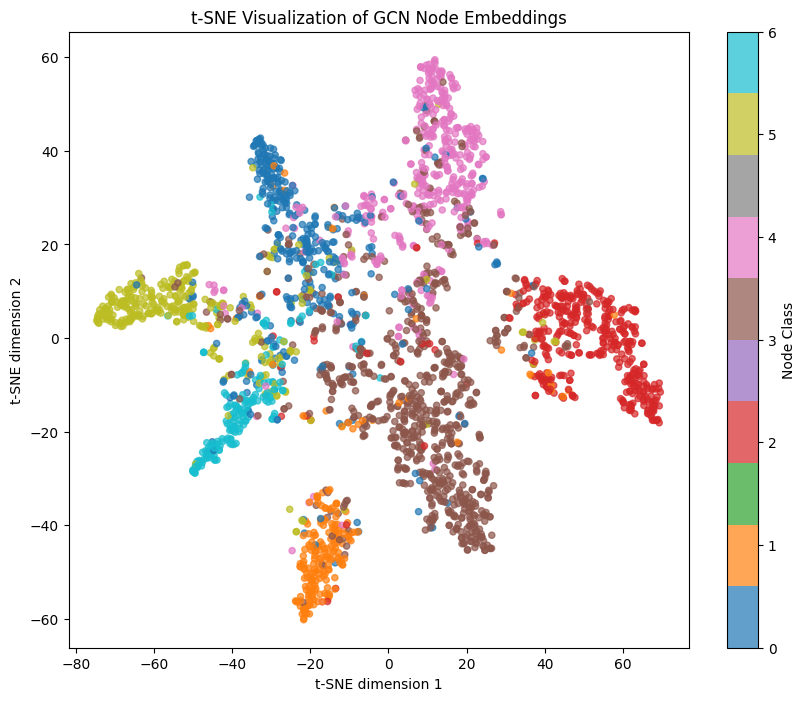

In [10]:
def get_node_embeddings(model, data):
    """Extract node embeddings from the second-to-last layer"""
    model.eval()
    with torch.no_grad():
        x = data.x
        edge_index = data.edge_index
        
        if isinstance(model, GCN):
            x = F.relu(model.conv1(x, edge_index))
            x = F.dropout(x, p=0.5, training=False)
            x = F.relu(model.conv2(x, edge_index))
        elif isinstance(model, GAT):
            x = F.dropout(x, p=0.6, training=False)
            x = F.elu(model.conv1(x, edge_index))
        else:  # Custom model
            x = F.relu(model.fc1(x))
            x = model.aggregate_neighbors(x, edge_index)
            x = F.relu(model.fc2(x))
    
    return x.cpu().numpy()

# Get embeddings
gcn_embeddings = get_node_embeddings(gcn_model, data)

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(gcn_embeddings)

# Plot embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=data.y.cpu().numpy(), cmap='tab10', 
                     alpha=0.7, s=20)
plt.colorbar(scatter, label='Node Class')
plt.title('t-SNE Visualization of GCN Node Embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

## Analyzing Attention Weights (GAT)

For GAT, we can visualize the attention weights to understand which neighbors are most important

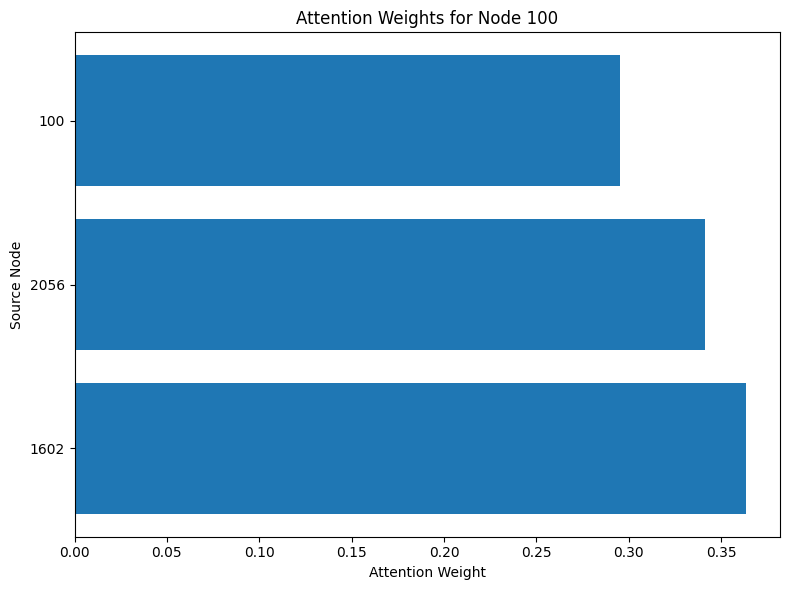

In [11]:
def visualize_attention_weights(model, data, node_idx):
    """Visualize attention weights for a specific node in GAT"""
    model.eval()
    
    # Get attention weights from first layer
    with torch.no_grad():
        _, (edge_index, attention_weights) = model.conv1(data.x, data.edge_index, 
                                                         return_attention_weights=True)
    
    # Find edges connected to the target node
    mask = edge_index[1] == node_idx
    source_nodes = edge_index[0][mask].cpu().numpy()
    weights = attention_weights[mask].mean(dim=1).cpu().numpy()  # Average over heads
    
    if len(source_nodes) == 0:
        print(f"Node {node_idx} has no incoming edges")
        return
    
    # Create visualization
    plt.figure(figsize=(8, 6))
    y_pos = np.arange(len(source_nodes))
    plt.barh(y_pos, weights)
    plt.yticks(y_pos, source_nodes)
    plt.xlabel('Attention Weight')
    plt.ylabel('Source Node')
    plt.title(f'Attention Weights for Node {node_idx}')
    plt.tight_layout()
    plt.show()

# Visualize attention for a random node
visualize_attention_weights(gat_model, data, node_idx=100)

## Node Classification Performance Analysis

GCN Model Performance:
Classification Report:
                        precision    recall  f1-score   support

            Case Based       0.64      0.72      0.68       130
    Genetic Algorithms       0.79      0.88      0.83        91
       Neural Networks       0.83      0.90      0.86       144
 Probabilistic Methods       0.91      0.71      0.80       319
Reinforcement Learning       0.77      0.81      0.79       149
         Rule Learning       0.81      0.75      0.78       103
                Theory       0.62      0.91      0.74        64

              accuracy                           0.79      1000
             macro avg       0.77      0.81      0.78      1000
          weighted avg       0.80      0.79      0.79      1000



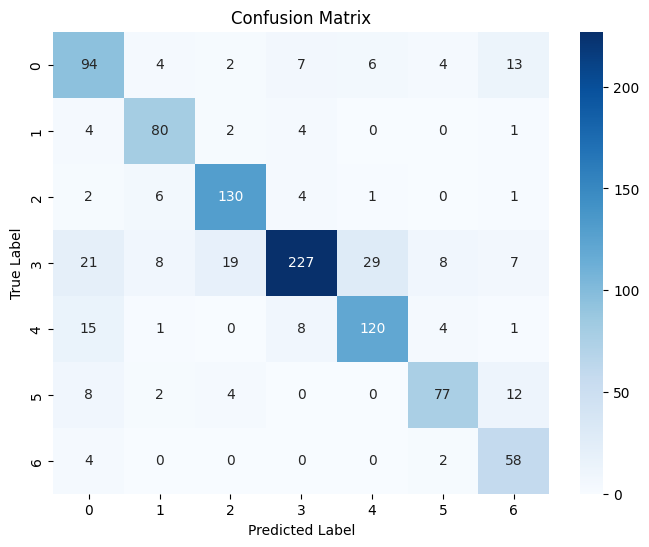

In [12]:
# Get detailed classification report
def get_classification_report(model, data, mask, class_names=None):
    """Get detailed classification metrics"""
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index).argmax(dim=1)
        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return cm

# Class names for Cora dataset
class_names = ['Case Based', 'Genetic Algorithms', 'Neural Networks', 
               'Probabilistic Methods', 'Reinforcement Learning', 
               'Rule Learning', 'Theory']

print("GCN Model Performance:")
cm = get_classification_report(gcn_model, data, data.test_mask, class_names)

## Over-smoothing Analysis

One common issue with deep GNNs is over-smoothing: node representations become too similar as we add more layers


Training 2-layer GCN...
Test accuracy: 0.8060

Training 4-layer GCN...
Test accuracy: 0.7580

Training 8-layer GCN...
Test accuracy: 0.4730

Training 16-layer GCN...
Test accuracy: 0.1640


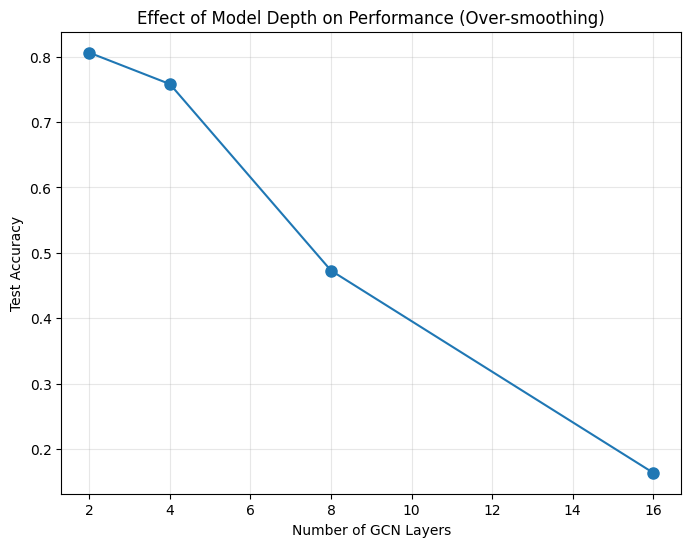

In [13]:
class DeepGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_layers=2):
        super(DeepGCN, self).__init__()
        self.convs = nn.ModuleList()
        
        # First layer
        self.convs.append(GCNConv(num_features, hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        
        # Output layer
        self.convs.append(GCNConv(hidden_dim, num_classes))
        
        self.dropout = 0.5
        
    def forward(self, x, edge_index):
        embeddings = []
        
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            embeddings.append(x)
        
        x = self.convs[-1](x, edge_index)
        
        return F.log_softmax(x, dim=1), embeddings

# Compare models with different depths
depths = [2, 4, 8, 16]
test_accs_by_depth = []

for depth in depths:
    print(f"\nTraining {depth}-layer GCN...")
    model = DeepGCN(data.num_node_features, 16, dataset.num_classes, num_layers=depth).to(device)
    
    # Train for fewer epochs
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out, _ = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        pred, _ = model(data.x, data.edge_index)
        pred = pred.argmax(dim=1)
        test_acc = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        test_accs_by_depth.append(test_acc)
        print(f"Test accuracy: {test_acc:.4f}")

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(depths, test_accs_by_depth, 'o-', markersize=8)
plt.xlabel('Number of GCN Layers')
plt.ylabel('Test Accuracy')
plt.title('Effect of Model Depth on Performance (Over-smoothing)')
plt.grid(True, alpha=0.3)
plt.show()

## Exercises

Now it's your turn to experiment with GNNs! Try these exercises:

### Exercise 1: Implement GraphSAGE
Implement a GraphSAGE layer that samples and aggregates features from a node's neighborhood

In [14]:
# Exercise 1: Implement GraphSAGE
class GraphSAGELayer(nn.Module):
    def __init__(self, in_features, out_features, aggregator='mean'):
        super(GraphSAGELayer, self).__init__()
        self.aggregator = aggregator
        
        # TODO: Define linear transformations for self and neighbor features
        # self.W_self = ...
        # self.W_neigh = ...
        
    def forward(self, x, edge_index):
        # TODO: Implement GraphSAGE forward pass
        # 1. Aggregate neighbor features
        # 2. Concatenate with self features
        # 3. Apply transformations
        pass

# Build and train a GraphSAGE model
# class GraphSAGE(nn.Module):
#     def __init__(self, num_features, hidden_dim, num_classes):
#         super(GraphSAGE, self).__init__()
#         # TODO: Build GraphSAGE model using your layer
#         pass

### Exercise 2: Edge Prediction
Modify the GNN for link prediction instead of node classification

In [15]:
# Exercise 2: Implement edge prediction
class LinkPredictionGNN(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(LinkPredictionGNN, self).__init__()
        # TODO: Define GNN layers for node embeddings
        pass
    
    def encode(self, x, edge_index):
        # TODO: Generate node embeddings
        pass
    
    def decode(self, z, edge_index):
        # TODO: Predict edge probability from node embeddings
        # Hint: Use dot product or MLP on concatenated embeddings
        pass
    
    def forward(self, x, edge_index, edge_label_index):
        # TODO: Complete forward pass
        pass

# Create train/test edge splits and train the model

### Exercise 3: Graph Classification
Implement a GNN for graph-level classification (e.g., molecular property prediction)

In [16]:
# Exercise 3: Graph classification
class GraphClassificationGNN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GraphClassificationGNN, self).__init__()
        # TODO: Define GNN layers
        # TODO: Define pooling layer (global_mean_pool, global_max_pool, etc.)
        # TODO: Define classifier layers
        pass
    
    def forward(self, x, edge_index, batch):
        # TODO: Implement forward pass
        # 1. Apply GNN layers
        # 2. Pool node features to get graph representation
        # 3. Apply classifier
        pass

# Load a graph classification dataset (e.g., PROTEINS, MUTAG)
# from torch_geometric.datasets import TUDataset
# dataset = TUDataset(root='./data', name='PROTEINS')

### Exercise 4: Implement Spectral Graph Convolution
Implement graph convolution from the spectral perspective using eigendecomposition

In [17]:
# Exercise 4: Spectral convolution
def spectral_conv(x, edge_index, num_nodes):
    """
    Implement spectral graph convolution
    
    Hint:
    1. Compute graph Laplacian
    2. Compute eigendecomposition
    3. Filter in spectral domain
    4. Transform back
    """
    # TODO: Implement spectral convolution
    pass

# Compare with spatial convolution

## Summary

In this tutorial, we've covered:

1. **Graph Neural Networks**: Processing graph-structured data
2. **Message Passing**: The core mechanism of GNNs
3. **Popular Architectures**: GCN, GAT, and custom implementations
4. **Node Classification**: Predicting labels for nodes in a graph
5. **Visualization**: Understanding learned representations and attention
6. **Common Issues**: Over-smoothing in deep GNNs

Key takeaways:
- GNNs aggregate information from neighborhoods
- Different aggregation methods (mean, attention) have different properties
- Depth in GNNs corresponds to the size of the receptive field
- GNNs can be applied to various tasks: node, edge, and graph-level

GNNs are a powerful tool for learning on graph-structured data and have applications in many domains!